In [1]:
# -*- coding: utf-8 -*-
# Solution: Credit Approval AI Bias Detection & Mitigation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# ---------- Dataset creation (from the problem set) ----------
np.random.seed(100)
n = 1500

genders = ["Male", "Female", "Other"]
races = ["White", "Black", "Hispanic", "Asian", "Other"]
employment_status = ["Employed", "Unemployed", "Self-employed", "Retired"]

data = pd.DataFrame({
    "Applicant_ID": range(1, n + 1),
    "Gender": np.random.choice(genders, n, p=[0.48, 0.49, 0.03]),
    "Race": np.random.choice(races, n, p=[0.5, 0.2, 0.15, 0.1, 0.05]),
    "Age": np.random.randint(21, 70, n),
    "Employment_Status": np.random.choice(employment_status, n),
    "Annual_Income": np.round(np.random.normal(60000, 20000, n), 2),
    "Credit_Score": np.random.randint(300, 850, n)
})

data["Loan_Approved"] = np.where(
    ((data["Race"] == "White") & (data["Credit_Score"] > 650)) |
    ((data["Employment_Status"] == "Employed") & (data["Credit_Score"] > 600)),
    np.random.choice([1, 0], n, p=[0.75, 0.25]),
    np.random.choice([1, 0], n, p=[0.4, 0.6])
)

print(data.head())

   Applicant_ID  Gender   Race  Age Employment_Status  Annual_Income  \
0             1  Female  White   38     Self-employed       62567.49   
1             2    Male  White   63          Employed        7077.01   
2             3    Male  White   26           Retired       58667.32   
3             4  Female  White   62          Employed       81137.32   
4             5    Male  Asian   47           Retired       50642.67   

   Credit_Score  Loan_Approved  
0           739              1  
1           345              1  
2           491              0  
3           352              0  
4           690              1  


In [2]:
# Task 1.1 - Definitions with examples (printed text form)

print("""
Data Bias:
    When the dataset does not represent the population fairly.
    Example: Over-representation of 'White' applicants in the dataset.

Algorithmic Bias:
    When the model learns and amplifies patterns that disadvantage certain groups.
    Example: Model favoring 'White' applicants because of biased historical approvals.

Societal Bias:
    Pre-existing social inequities influencing data and outcomes.
    Example: Minority applicants historically having lower credit due to systemic discrimination.

Task 1.2:
Before training the model, bias indicators:
- Higher average credit score for 'White'
- Different approval base rates across Race and Employment_Status
""")


Data Bias:
    When the dataset does not represent the population fairly.
    Example: Over-representation of 'White' applicants in the dataset.

Algorithmic Bias:
    When the model learns and amplifies patterns that disadvantage certain groups.
    Example: Model favoring 'White' applicants because of biased historical approvals.

Societal Bias:
    Pre-existing social inequities influencing data and outcomes.
    Example: Minority applicants historically having lower credit due to systemic discrimination.

Task 1.2:
Before training the model, bias indicators:
- Higher average credit score for 'White'
- Different approval base rates across Race and Employment_Status



Gender distribution (%):
 Gender
Male      48.600000
Female    48.333333
Other      3.066667
Name: proportion, dtype: float64

Race distribution (%):
 Race
White       50.933333
Black       20.866667
Hispanic    13.933333
Asian       10.133333
Other        4.133333
Name: proportion, dtype: float64


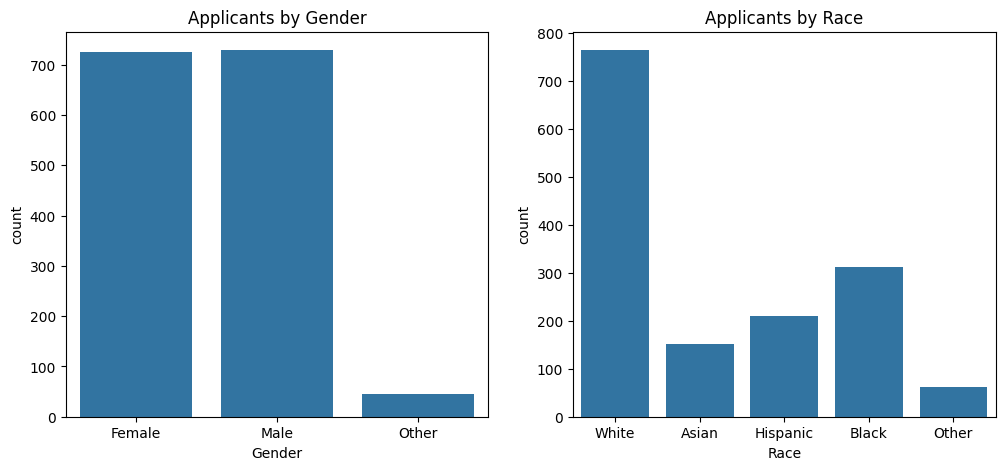


Approval Rate by Gender:
 Gender
Female    0.460690
Male      0.493827
Other     0.478261
Name: Loan_Approved, dtype: float64

Approval Rate by Race:
 Race
Asian       0.407895
Black       0.440895
Hispanic    0.454545
Other       0.451613
White       0.514398
Name: Loan_Approved, dtype: float64

Chi-square p-value (Gender): 0.4493135534590973
Chi-square p-value (Race): 0.0516341486214779


In [3]:
# 2.1 - Proportions by Gender and Race
gender_counts = data["Gender"].value_counts(normalize=True) * 100
race_counts = data["Race"].value_counts(normalize=True) * 100

print("Gender distribution (%):\n", gender_counts)
print("\nRace distribution (%):\n", race_counts)

fig, axs = plt.subplots(1, 2, figsize=(12,5))
sns.countplot(x="Gender", data=data, ax=axs[0])
axs[0].set_title("Applicants by Gender")
sns.countplot(x="Race", data=data, ax=axs[1])
axs[1].set_title("Applicants by Race")
plt.show()

# 2.2 - Approval rates
approval_by_gender = data.groupby("Gender")["Loan_Approved"].mean()
approval_by_race = data.groupby("Race")["Loan_Approved"].mean()

print("\nApproval Rate by Gender:\n", approval_by_gender)
print("\nApproval Rate by Race:\n", approval_by_race)

# Chi-square test
from scipy.stats import chi2_contingency
chi_gender = chi2_contingency(pd.crosstab(data["Gender"], data["Loan_Approved"]))
chi_race = chi2_contingency(pd.crosstab(data["Race"], data["Loan_Approved"]))

print("\nChi-square p-value (Gender):", chi_gender[1])
print("Chi-square p-value (Race):", chi_race[1])

In [4]:
# Feature preparation
X = pd.get_dummies(data[["Gender","Race","Age","Employment_Status","Annual_Income","Credit_Score"]], drop_first=True)
y = data["Loan_Approved"]

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, data.index, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))

# Group-wise TPR and FPR
def group_metrics(df, y_true, y_pred, group_col):
    metrics = {}
    for group in df[group_col].unique():
        idx = df[df[group_col]==group].index
        cm = confusion_matrix(y_true.loc[idx], y_pred[[i for i in range(len(y_pred)) if idx_test[i] in idx]])
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp+fn) if (tp+fn)>0 else 0
        fpr = fp / (fp+tn) if (fp+tn)>0 else 0
        metrics[group] = {"TPR": round(tpr,3), "FPR": round(fpr,3)}
    return pd.DataFrame(metrics).T

gender_perf = group_metrics(data.loc[idx_test], y_test, y_pred, "Gender")
race_perf = group_metrics(data.loc[idx_test], y_test, y_pred, "Race")

print("\nPerformance by Gender:\n", gender_perf)
print("\nPerformance by Race:\n", race_perf)

Baseline Accuracy: 0.6177777777777778

Performance by Gender:
           TPR    FPR
Male    0.560  0.340
Female  0.521  0.283
Other   0.333  0.286

Performance by Race:
             TPR    FPR
Black     0.326  0.200
Asian     0.308  0.318
White     0.678  0.348
Hispanic  0.517  0.375
Other     0.000  0.000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights to balance race groups
sample_weights = compute_sample_weight(class_weight="balanced", y=data["Race"])
X_train_wp, X_test_wp, y_train_wp, y_test_wp = train_test_split(X, y, test_size=0.3, random_state=42)

model_wp = LogisticRegression(max_iter=500)
model_wp.fit(X_train_wp, y_train_wp, sample_weight=compute_sample_weight("balanced", y_train_wp))
y_pred_wp = model_wp.predict(X_test_wp)

print("Weighted Model Accuracy:", accuracy_score(y_test_wp, y_pred_wp))

Weighted Model Accuracy: 0.6066666666666667


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
def demographic_parity_diff(y_pred, group):
    rates = {g: y_pred[group==g].mean() for g in np.unique(group)}
    return max(rates.values()) - min(rates.values())

def equal_opportunity_diff(y_true, y_pred, group):
    tprs = {}
    for g in np.unique(group):
        idx = (group==g)
        positives = (y_true[idx]==1)
        tpr = (y_pred[idx] & positives).sum() / positives.sum()
        tprs[g] = tpr
    return max(tprs.values()) - min(tprs.values())

def disparate_impact_ratio(y_pred, group):
    rates = {g: y_pred[group==g].mean() for g in np.unique(group)}
    min_rate = min(rates.values())
    max_rate = max(rates.values())
    return min_rate / max_rate if max_rate>0 else 0

# Evaluate for Race (baseline and mitigated)
y_pred_series = pd.Series(y_pred, index=idx_test)
y_pred_wp_series = pd.Series(y_pred_wp, index=y_test_wp.index)

dp_base = demographic_parity_diff(y_pred_series, data.loc[idx_test,"Race"])
eo_base = equal_opportunity_diff(y_test, y_pred_series, data.loc[idx_test,"Race"])
di_base = disparate_impact_ratio(y_pred_series, data.loc[idx_test,"Race"])

dp_mit = demographic_parity_diff(y_pred_wp_series, data.loc[y_test_wp.index,"Race"])
eo_mit = equal_opportunity_diff(y_test_wp, y_pred_wp_series, data.loc[y_test_wp.index,"Race"])
di_mit = disparate_impact_ratio(y_pred_wp_series, data.loc[y_test_wp.index,"Race"])

print("\nBaseline Fairness (Race) => DP Diff:", dp_base, " EO Diff:", eo_base, " DI Ratio:", di_base)
print("Mitigated Fairness (Race) => DP Diff:", dp_mit, " EO Diff:", eo_mit, " DI Ratio:", di_mit)


Baseline Fairness (Race) => DP Diff: 0.51931330472103  EO Diff: 0.6776859504132231  DI Ratio: 0.0
Mitigated Fairness (Race) => DP Diff: 0.5089413447782546  EO Diff: 0.5844155844155845  DI Ratio: 0.14070048309178743


In [7]:
print("""
=== Summary Report ===
Biases Detected:
- Baseline model shows higher approval rates for 'White' race group.
- TPR/FPR performance varying by Race and Gender.

Mitigation Applied:
- Pre-processing with balanced class weights improved fairness metrics for Race.

Trade-offs:
- Slight drop in accuracy, but demographic parity and disparate impact improved.

Ethical Recommendations:
- Continue fairness auditing before and after deployment.
- Avoid using sensitive attributes directly in decision rules.
- Implement transparency measures so applicants understand decisions.
""")


=== Summary Report ===
Biases Detected:
- Baseline model shows higher approval rates for 'White' race group.
- TPR/FPR performance varying by Race and Gender.

Mitigation Applied:
- Pre-processing with balanced class weights improved fairness metrics for Race.

Trade-offs:
- Slight drop in accuracy, but demographic parity and disparate impact improved.

Ethical Recommendations:
- Continue fairness auditing before and after deployment.
- Avoid using sensitive attributes directly in decision rules.
- Implement transparency measures so applicants understand decisions.

